In [35]:
# Modues to be used
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import time
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Load data from pickle files

# -> Player dictionary with the dataFrames
f = open('data/dict_player.pickle', 'rb')
dict_player = pickle.load(f)

# -> Map dataFrames
f = open('data/df_map.pickle','rb')
df_map = pickle.load(f)

# -> Map dictionary
f = open('data/dict_map.pickle','rb')
dict_map = pickle.load(f)

# Save a list of the teams and their ranks

In [27]:
df_aux = df_map[ df_map['date']>datetime(2019,1,1) ]

df_1 = df_aux.drop(columns=['map', 'event_id', 'event_name',
       'team_score_1', 'team_kills_1', 'team_deaths_1',
       'team_assists_1','team_id_2', 'team_name_2',
       'team_score_2', 'team_kills_2', 'team_deaths_2', 'team_assists_2',
       'team_rank_2', 'winner']).reset_index()

df_1 = df_1.rename(columns={'team_id_1':'team_id', 'team_name_1':'team_name','team_rank_1':'team_rank'})


df_2 = df_aux.drop(columns=[ 'map', 'event_id', 'event_name',
       'team_score_1', 'team_kills_1', 'team_deaths_1',
       'team_assists_1','team_id_1', 'team_name_1',
       'team_score_2', 'team_kills_2', 'team_deaths_2', 'team_assists_2',
       'team_rank_1', 'winner']).reset_index()

df_2 = df_2.rename(columns={'team_id_2':'team_id', 'team_name_2':'team_name','team_rank_2':'team_rank'})

df = df_1.append(df_2,sort=True,ignore_index=True)

df = df.sort_values('date',ascending=False)

team_id_vec = df.team_id.unique()

dict_team = {}
dict_player_new = {}
for team_id in team_id_vec:
    
    df_tmp = df[ df['team_id'] == team_id].head(n=1)

    dict_team[team_id] = {}
    dict_team[team_id]['team_name'] = df_tmp.team_name.values[0]
    dict_team[team_id]['team_rank'] = df_tmp.team_rank.values[0]
    dict_team[team_id]['team_prize'] = 0.0

    map_id = df_tmp.map_id.values[0]

    count = 0
    for player_id in dict_map[map_id][team_id]['players_id']:

        df_aux = dict_player[player_id][ dict_player[player_id]['date']>datetime(2019,1,1) ]

        prize_money   = df_aux['prize'].sum()
        player_rating = df_aux['rating'].mean()

        dict_player_new[player_id] = {}
        dict_player_new[player_id]['name']        = dict_player[player_id]['player_name'].values[0]
        dict_player_new[player_id]['prize_money'] = prize_money        
        
        dict_player_new[player_id]['rating']           = player_rating
        dict_player_new[player_id]['hs_kills']         = ( (df_aux['hs_kills']/(df_aux['team_score']+df_aux['op_score'])).mean() )
        dict_player_new[player_id]['kills_per_round']  = ( df_aux['kills_per_round'].mean() )
        dict_player_new[player_id]['deaths_per_round'] = ( df_aux['deaths_per_round'].mean() )
        dict_player_new[player_id]['ADR']              = ( df_aux['ADR'].mean() )
        dict_player_new[player_id]['KAST']             = ( df_aux['KAST'].mean() )
        dict_player_new[player_id]['assists']          = ( (df_aux['assists']/(df_aux['team_score']+df_aux['op_score'])).mean() )
        dict_player_new[player_id]['flash_assists']    = ( (df_aux['flash_assists']/(df_aux['team_score']+df_aux['op_score'])).mean() )
        dict_player_new[player_id]['first_kills_diff'] = ( (df_aux['first_kills_diff']/(df_aux['team_score']+df_aux['op_score'])).mean() )
        dict_player_new[player_id]['team_rank']        = ( df_aux['team_rank'].mean() )
        dict_player_new[player_id]['team_score']       = ( (df_aux['team_score']-df_aux['op_score']).mean() )
        dict_player_new[player_id]['win_rate']         = ( df_aux['win'].mean() )

        if prize_money > 0:
            dict_player_new[player_id]['prize_rating'] = np.log( prize_money ) / 12.0
        else:
            dict_player_new[player_id]['prize_rating'] = 0.0


        count = count + 1
        dict_team[team_id]['player_name_'+str(count)] = dict_player[player_id]['player_name'].values[0]
        dict_team[team_id]['player_id_'+str(count)] = dict_player[player_id]['player_id'].values[0]

        dict_team[team_id]['team_prize'] = dict_team[team_id]['team_prize'] + prize_money / 5.0

    if dict_team[team_id]['team_prize'] > 0.0:
        dict_team[team_id]['team_prize_rating'] = np.log( dict_team[team_id]['team_prize'] ) / 12.0
    else:
        dict_team[team_id]['team_prize_rating'] = 0.0



In [24]:
# Get the rating and prize rating of the average opponent for each team
df = pd.DataFrame.from_dict(dict_team,orient='index')
for team_id in df.index[:]:
    df_aux = df_map[ (df_map['date']>datetime(2019,1,1)) &  ( (df_map['team_id_1']==team_id) | (df_map['team_id_2']==team_id) ) ]

    prize_vec  = []
    rating_vec = []

    for map_id in df_aux.index:

        prize_rating = []
        rating       = []

        for new_team_id in dict_map[map_id]:
            if( new_team_id != team_id ):
                
                for player_id in dict_map[map_id][new_team_id]['players_id']:

                    try:
                        rating.append( dict_player_new[player_id]['rating'] )
                        prize_rating.append( dict_player_new[player_id]['prize_rating'] )
                    except:
                        continue
        
        if len(prize_rating) > 0:
            rating_vec.append( np.mean(rating) )
            prize_vec.append(  np.mean(prize_rating) )
            

    dict_team[team_id]['avg_op_rating']       = np.mean( rating_vec )
    dict_team[team_id]['avg_op_prize_rating'] = np.mean( prize_vec )

/home/emmanuel/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/emmanuel/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:

df = pd.DataFrame.from_dict(dict_team,orient='index')
df = df[ df['team_rank']>0 ]
df = df.sort_values(['team_prize_rating'],ascending=False)

df.head(n=20)
# filename = 'webapp_dict_team.sav'
# pickle.dump( df, open(filename,'wb') )

,team_name,team_rank,team_prize,player_name_1,player_id_1,player_name_2,player_id_2,player_name_3,player_id_3,player_name_4,player_id_4,player_name_5,player_id_5,team_prize_rating,avg_op_rating,avg_op_prize_rating
6665,Astralis,1,359750.000000,Xyp9x,4954,device,7592,gla1ve,7412,dupreeh,7398,Magisk,9032,1.066097,1.100374,0.914172
5973,Liquid,4,231225.000000,EliGE,8738,Stewie2K,8797,nitr0,7687,NAF,8520,Twistzz,10394,1.029262,1.103210,0.898377
4494,mousesports,4,145025.500000,ropz,11816,frozen,9960,chrisJ,2730,woxic,8574,karrigan,429,0.990389,1.101964,0.880509
9565,Vitality,8,139987.833333,ZywOo,11893,ALEX,8184,apEX,7322,shox,1225,RpK,7169,0.987443,1.088512,0.862232
10399,Evil Geniuses,5,137633.333333,Brehze,9136,Ethan,10671,stanislaw,8507,CeRq,11219,tarik,8523,0.986029,1.112033,0.911009
6673,NRG,3,137633.333333,Brehze,9136,Ethan,10671,tarik,8523,stanislaw,8507,CeRq,11219,0.986029,1.093910,0.859815
4869,ENCE,12,99305.466667,sergej,11916,Aerial,4076,allu,695,suNny,5479,xseveN,7248,0.958830,1.098296,0.893444
5378,Virtus.pro,15,87330.333333,buster,11942,qikert,13239,AdreN,334,Jame,13776,SANJI,11716,0.948121,1.075882,0.803834
8120,AVANGAR,11,87330.333333,buster,11942,SANJI,11716,qikert,13239,Jame,13776,AdreN,334,0.948121,1.075634,0.811389
6667,FaZe,8,81292.666667,NiKo,3741,coldzera,9216,olofmeister,885,rain,8183,broky,18053,0.942151,1.094393,0.898625


In [19]:
response.wr

b'<?xml version="1.0" encoding="utf-8"?>\n<!-- Generator: Adobe Illustrator 23.0.4, SVG Export Plug-In . SVG Version: 6.00 Build 0)  -->\n<svg version="1.1" id="Layer_1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" x="0px" y="0px"\n\t viewBox="0 0 186.3 186.3" width="800px" height="800px" style="enable-background:new 0 0 186.3 186.3;" xml:space="preserve">\n<style type="text/css">\n\t.st0{fill:#12233E;}\n\t.st1{fill:#FFFFFF;}\n</style>\n<g>\n\t<path id="base_4_" class="st0" d="M93.5,185.1c0,0-33.2-12.4-51.7-25.1c-27.9-19.3-29-46-29-99.4V28.9L93.5,1.1l80.7,27.8v31.7\n\t\tc0,53.4-1.1,80.1-29.1,99.4C126.7,172.8,93.5,185.1,93.5,185.1z"/>\n</g>\n<g id="new_1_">\n\t<g>\n\t\t<path class="st1" d="M43.6,111.4c-5.1,2.5-11.8,5.4-19.2,8.1c1.3,5.7,3.1,10.7,5.6,15.3c5.6-3.5,10.5-7.1,14.3-10.1\n\t\t\tC43.7,120,43.5,115.6,43.6,111.4z"/>\n\t\t<path class="st1" d="M56.1,69.8L56.1,69.8c-9.4-3.8-23.5-10.5-35.3-19.4v13c0,2.4,0,4.8,0,7.1c11,4.2,22.3,6.8,30.2,8.1\n\t\t\tC52.6

In [28]:
df = pd.DataFrame.from_dict(dict_player_new,orient='index')

df = df.sort_values(['prize_money'],ascending=False)

df_player_aux = df

# filename = 'webapp_dict_player.sav'
# pickle.dump( df, open(filename,'wb') )

df.head(n=50)

,name,prize_money,rating,hs_kills,kills_per_round,deaths_per_round,ADR,KAST,assists,flash_assists,first_kills_diff,team_rank,team_score,win_rate,prize_rating
4954,Xyp9x,359750.000000,1.153648,0.270269,0.679747,0.571139,76.026415,75.623899,0.214533,0.055280,0.006686,1.622642,4.150943,0.742138,1.066097
7592,device,359750.000000,1.266101,0.259231,0.785886,0.590000,82.334591,73.359119,0.172389,0.038667,0.053338,1.622642,4.150943,0.742138,1.066097
9032,Magisk,359750.000000,1.199623,0.325160,0.730253,0.600253,81.106918,75.594340,0.195366,0.033972,0.007082,1.622642,4.150943,0.742138,1.066097
7398,dupreeh,359750.000000,1.155220,0.354658,0.718228,0.605949,74.968553,73.676101,0.158102,0.027587,0.019163,1.622642,4.150943,0.742138,1.066097
7412,gla1ve,359750.000000,1.101195,0.286380,0.665759,0.632532,74.671069,70.859119,0.225827,0.066152,-0.004838,1.622642,4.150943,0.742138,1.066097
8797,Stewie2K,232041.666667,1.106953,0.306580,0.671631,0.643391,75.139485,70.584979,0.182689,0.049925,0.008802,1.866953,3.339056,0.690987,1.029556
10394,Twistzz,231541.666667,1.172511,0.478346,0.721525,0.582556,74.646188,75.714350,0.152077,0.040362,0.003791,1.950673,3.318386,0.690583,1.029376
8520,NAF,231541.666667,1.213964,0.309280,0.735631,0.605495,82.978829,74.609910,0.219813,0.065499,0.028773,1.959459,3.315315,0.689189,1.029376
8738,EliGE,231541.666667,1.242018,0.405152,0.789372,0.646413,86.518834,71.825561,0.182193,0.035011,0.017776,1.950673,3.318386,0.690583,1.029376
7687,nitr0,229458.333333,1.076968,0.273931,0.648643,0.606923,69.035294,72.698190,0.206850,0.087175,0.010758,1.941176,3.253394,0.683258,1.028623


/home/emmanuel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
/home/emmanuel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
prize_stars
rating_stars
/home/emmanuel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
hs_stars
/home/emmanuel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
kills_stars
win_stars
/home/emmanuel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]

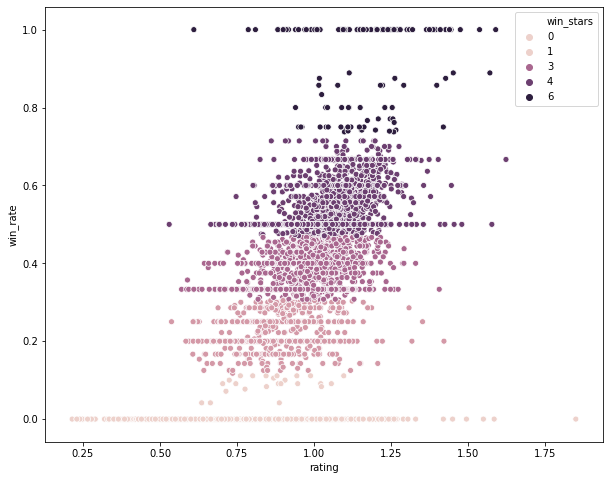

In [118]:
from sklearn.cluster import KMeans

df_with_stars = df.copy()

n_clusters = 5

# Add the star ratings for several metics
metrics_vec = ['prize_rating', 'rating', 'hs_kills', 'kills_per_round', 'win_rate']
stars_vec   = ['prize_stars', 'rating_stars', 'hs_stars', 'kills_stars', 'win_stars']

for ind_met in range( 0, len(metrics_vec) ):

    X = pd.DataFrame.as_matrix(df_with_stars,columns=[metrics_vec[ind_met]])
    #X = pd.DataFrame.as_matrix(df_tmp,columns=['prize_rating'])
    #X = df_tmp.values(columns=['rating','prize_money'])
    #X = df_tmp.values(columns=['prize_rating'])
    #
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    #df_tmp.sort_values('rating',ascending=False)[:30]

    #Z = df_tmp.index.values

    #df_tmp['label'] = kmeans.labels_

    n = n_clusters
    order = np.argsort( kmeans.cluster_centers_[:,0] )[::-1][:n]

    prize_stars = kmeans.labels_
    for ind in range(0,n_clusters):
        prize_stars[kmeans.labels_==order[ind]] = -5+ind

    print(stars_vec[ind_met])
    df_with_stars[stars_vec[ind_met]] = prize_stars*-1



plt.figure(figsize=(10,8));
sns.scatterplot(data=df_with_stars,x='rating',y='win_rate',hue='win_stars');
#plt.figure(figsize=(10,8));
#sns.scatterplot(data=df,x='rating',y='prize_money',hue=kmeans.labels_,size=kmeans.labels_);

filename = 'webapp_dict_player.sav'
pickle.dump( df_with_stars, open(filename,'wb') )


In [113]:
df_with_stars.head(n=50)

,name,prize_money,rating,hs_kills,kills_per_round,deaths_per_round,ADR,KAST,assists,flash_assists,first_kills_diff,team_rank,team_score,win_rate,prize_rating,prize_stars,rating_stars,hs_stars,kills_stars,win_stars
4954,Xyp9x,359750.000000,1.153648,0.270269,0.679747,0.571139,76.026415,75.623899,0.214533,0.055280,0.006686,1.622642,4.150943,0.742138,1.066097,5,5,2,4,5
7592,device,359750.000000,1.266101,0.259231,0.785886,0.590000,82.334591,73.359119,0.172389,0.038667,0.053338,1.622642,4.150943,0.742138,1.066097,5,5,2,5,5
9032,Magisk,359750.000000,1.199623,0.325160,0.730253,0.600253,81.106918,75.594340,0.195366,0.033972,0.007082,1.622642,4.150943,0.742138,1.066097,5,5,3,4,5
7398,dupreeh,359750.000000,1.155220,0.354658,0.718228,0.605949,74.968553,73.676101,0.158102,0.027587,0.019163,1.622642,4.150943,0.742138,1.066097,5,5,4,4,5
7412,gla1ve,359750.000000,1.101195,0.286380,0.665759,0.632532,74.671069,70.859119,0.225827,0.066152,-0.004838,1.622642,4.150943,0.742138,1.066097,5,4,3,4,5
8797,Stewie2K,232041.666667,1.106953,0.306580,0.671631,0.643391,75.139485,70.584979,0.182689,0.049925,0.008802,1.866953,3.339056,0.690987,1.029556,5,4,3,4,4
10394,Twistzz,231541.666667,1.172511,0.478346,0.721525,0.582556,74.646188,75.714350,0.152077,0.040362,0.003791,1.950673,3.318386,0.690583,1.029376,5,5,5,4,4
8520,NAF,231541.666667,1.213964,0.309280,0.735631,0.605495,82.978829,74.609910,0.219813,0.065499,0.028773,1.959459,3.315315,0.689189,1.029376,5,5,3,4,4
8738,EliGE,231541.666667,1.242018,0.405152,0.789372,0.646413,86.518834,71.825561,0.182193,0.035011,0.017776,1.950673,3.318386,0.690583,1.029376,5,5,4,5,4
7687,nitr0,229458.333333,1.076968,0.273931,0.648643,0.606923,69.035294,72.698190,0.206850,0.087175,0.010758,1.941176,3.253394,0.683258,1.028623,5,4,3,3,4


In [79]:
n=5
print(kmeans.cluster_centers_[:,0])

order = np.argsort( kmeans.cluster_centers_[:,0] )[::-1][:n]
print(order)

np.where(order==1)[0][0]

print(kmeans.labels_)

val = np.copy(kmeans.labels_)
val[kmeans.labels_==4]=-5
print(val)

[ 4.83132383e-01 -6.77236045e-15  6.25602008e-01  3.38503121e-01
  8.38458089e-01]
[4 2 0 3 1]
[4 4 4 ... 1 1 1]
[-5 -5 -5 ...  1  1  1]


# Now we take care of the player data

In [184]:
# First we take all the players in ranked teams from 2019
player_aux = {}

for player_id in df_player_aux.index:
    df_aux = dict_player[player_id][ dict_player[player_id]['date']>datetime(2019,1,1) ]

    if any( df_aux['team_rank']>0 ):
        player_aux[player_id] = {}

        prize = sum( df_aux['prize'] )
        if prize > 0.0:
            player_aux[player_id]['prize'] = np.log( prize ) / 12.0
        else:
            player_aux[player_id]['prize'] = 0.0

        player_aux[player_id]['name']             = df_aux['player_name'].values[0]
        player_aux[player_id]['rating']           = df_aux['rating'].mean()
        player_aux[player_id]['hs_perc']          = (df_aux['hs_kills']/df_aux['kills']).mean()
        player_aux[player_id]['kills_per_round']  = df_aux['kills_per_round'].mean()
        player_aux[player_id]['deaths_per_round'] = df_aux['deaths_per_round'].mean()
        player_aux[player_id]['ADR']              = df_aux['ADR'].mean()

        # print( df_aux['player_name'].unique() )

In [200]:
df.head()

,prize,name,rating,hs_perc,kills_per_round,deaths_per_round,ADR,dist
4954,0.180993,Xyp9x,1.692562,0.310975,4.560648,0.135682,1.673338,8.554198
7592,0.180993,device,0.161589,1.862233,0.627102,0.000339,0.171326,3.003582
9032,0.180993,Magisk,0.871309,0.008239,2.238562,0.029518,0.342355,3.670977
7398,0.180993,dupreeh,1.660014,0.449086,2.717279,0.077001,2.076747,7.161119
7412,0.180993,gla1ve,2.959497,0.014347,5.348304,0.593945,2.198031,11.295116


In [201]:
# Using Euclidean distance
player_id = 7998

df = pd.DataFrame.from_dict(player_aux,orient='index')

df.head()
# df.prize = (df.prize - df.prize.mean()) / df.prize.std()
# df.rating = (df.rating - df.rating.mean()) / df.rating.std()

column_vec = ['prize', 'rating', 'hs_perc', 'kills_per_round',
       'deaths_per_round', 'ADR']

for column in column_vec:
    df[column] = (df[column] - df[column].mean()) / df[column].std()


filename = 'webapp_dict_similarity.sav'
pickle.dump( df, open(filename,'wb') )

df.head(n=50) 
    
df_dist = df
df_dist['dist'] = df['rating']*0.0
for column in column_vec:
    df_dist[column] = (df[column]-df.loc[player_id][column])**2
    df_dist['dist'] = df_dist['dist'] + df_dist[column]


df_dist = df_dist.sort_values('dist',ascending=True)
# for player_id in df_dist.index[:50]:
#     print( dict_player[player_id].player_name.unique() )

df_dist.head(n=20)

,prize,name,rating,hs_perc,kills_per_round,deaths_per_round,ADR,dist
7998,0.000000,s1mple,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11893,0.024323,ZywOo,0.063620,0.258265,0.007433,0.001052,0.038583,0.393276
14401,0.163495,Emy,0.231104,0.197952,0.631801,0.583759,0.003915,1.812025
11140,0.448670,INS,0.324695,0.038367,0.894672,0.220050,0.000219,1.926673
9115,0.207457,dexter,0.211265,0.779015,0.401553,0.479953,0.001648,2.080891
7131,0.108173,BnTeT,0.464817,0.033568,1.580457,0.024613,0.073174,2.284803
11188,0.311317,xeta,0.160556,0.395839,1.347949,0.082227,0.085682,2.383570
8918,0.000000,electronic,0.459596,0.184336,1.298777,0.454710,0.005570,2.402990
8944,0.684594,Benkai,0.403801,0.612632,0.664064,0.106128,0.028816,2.500036
16816,0.532967,vsm,0.201363,0.022802,0.231854,1.491507,0.095870,2.576364


In [179]:
df.head()

,prize,rating,hs_perc,kills_per_round,deaths_per_round,ADR,dist
4954,0.180993,1.692562,0.310975,4.560648,0.135682,1.673338,146.348592
7592,0.180993,0.161589,1.862233,0.627102,0.000339,0.171326,18.043008
9032,0.180993,0.871309,0.008239,2.238562,0.029518,0.342355,26.952138
7398,0.180993,1.660014,0.449086,2.717279,0.077001,2.076747,102.563246
7412,0.180993,2.959497,0.014347,5.348304,0.593945,2.198031,255.159301


In [20]:
# Scrape for logos
for team_id in df.index.values[:10]:
    print(team_id)
    user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'

    url = "https://static.hltv.org/images/team/logo/"+str(team_id)
    headers={'User-Agent':user_agent,} 

    request=urllib.request.Request(url,None,headers) #The assembled request
    response = urllib.request.urlopen(request)
    data = response.read()
    print("https://static.hltv.org/images/team/logo/"+str(team_id))
    #urllib.request.urlretrieve("https://static.hltv.org/images/team/logo/"+str(team_id), "logo_scrape/"+str(team_id)+".svg")
    #urllib.request.urlretrieve(request, "logo_scrape/"+str(team_id)+".svg")
    #https://static.hltv.org/images/team/logo/6665
    with open("logo_scrape/"+str(team_id)+".svg", 'wb') as f:
        f.write(data)
    time.sleep(3)

6665
https://static.hltv.org/images/team/logo/6665
5973
https://static.hltv.org/images/team/logo/5973
4494
https://static.hltv.org/images/team/logo/4494
9565
https://static.hltv.org/images/team/logo/9565
10399
https://static.hltv.org/images/team/logo/10399
6673
https://static.hltv.org/images/team/logo/6673
4869
https://static.hltv.org/images/team/logo/4869
5378
https://static.hltv.org/images/team/logo/5378
8120
https://static.hltv.org/images/team/logo/8120
6667
https://static.hltv.org/images/team/logo/6667
